# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [2]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation..

    Parameters
    ----------
    layers : list of int
        Neural network architecture, each entry defines the number of neurons in that layer.
    hbar : float, optional
        Reduced Planck's constant (default is 1.0).
    m : float, optional
        Mass of the particle (default is 1.0).
    g : float, optional
        Interaction strength (default is 100.0).
    """
    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0):
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

    def build_network(self):
        """
        Build the neural network with sine activation functions between layers.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def forward(self, inputs):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor containing spatial points (collocation points).

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution.
        """
        return self.network(inputs)

    def compute_potential(self, x, potential_type="gaussian", a=0.5, l=1.0):
        """
        Compute a symmetric potential function for the 1D domain.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        potential_type : str, optional
            Type of potential ('gaussian' or 'sine'), by default "gaussian".
        a : float, optional
            Center of the potential (for Gaussian), by default 0.5.
        l : float, optional
            Length scale for sine potential, by default 1.0.

        Returns
        -------
        V : torch.Tensor
            Tensor of symmetric potential values at the input points.

        Raises
        ------
        ValueError
            If the potential type is not recognized.
        """
        # Gaussian potential centered at `a`
        if potential_type == "gaussian":
            V = torch.exp(-(x - a) ** 2)
        # Sine potential symmetric about the center of the domain
        else:
            V = torch.sin(torch.pi * (x - (a - l / 2)) / l)

        return V

    def boundary_loss(self, boundary_points, boundary_values):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(boundary_points)
        return torch.mean((u_pred - boundary_values) ** 2)

    def riesz_loss(self, predictions, inputs, eta):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        eta : float
            Interaction strength.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """
        u = predictions

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.mean(u_x ** 2) # Kinetic term
        V = self.compute_potential(inputs)
        potential_term = torch.mean(V * u ** 2) # Potential term
        interaction_term = 0.5 * eta * torch.mean(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)

        return riesz_energy

    def pde_loss(self, inputs, predictions, eta):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        predictions : torch.Tensor
            Predicted solution from the network.
        eta : float
            Interaction strength.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        u = predictions

        # Compute first and second derivatives with respect to x
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        V = self.compute_potential(inputs)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + eta * u ** 4) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        pde_residual = -u_xx + V * u + eta * torch.abs(u ** 2) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2) #+ L_lambda + L_f

        return pde_loss, pde_residual, lambda_pde

    def symmetry_loss(self, collocation_points):
        """
        Compute the symmetry loss to enforce u(x) = u(1-x).

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of interior spatial points.

        Returns
        -------
        sym_loss : torch.Tensor
            The mean squared error enforcing symmetry u(x) = u(1-x).
        """
        # Reflect points across the center of the domain
        x_reflected = 1 - collocation_points

        # Predict u(x) and u(1-x) using the model
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # Compute mean squared difference to enforce symmetry
        sym_loss = torch.mean((u_original - u_reflected) ** 2)

        return sym_loss

    def total_loss(self, collocation_points, boundary_points, boundary_values, eta, B, R, P, N, S):
        """
        Compute the total loss combining boundary loss, Riesz energy loss,
        PDE loss, L^2 norm regularization loss, and symmetry loss.

        Parameters
        ----------
        collocation_points : torch.Tensor
            Input tensor of spatial coordinates for the interior points.
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        u_bc : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        eta : float
            Interaction strength.
        B : int
            Weight for boundary loss.
        R : int
            Weight for Riesz energy loss.
        P : int
            Weight for PDE loss.
        N : int
            Weight for L^2 norm equals 1.
        S : int
            Weight for symmetry loss.

        Returns
        -------
        total_loss : torch.Tensor
            Total loss value.
        """

        data_loss = self.boundary_loss(boundary_points, boundary_values)
        riesz_energy = self.riesz_loss(self.forward(collocation_points), collocation_points, eta)
        pde_loss, _, _ = self.pde_loss(collocation_points, self.forward(collocation_points), eta)
        norm_loss = (torch.norm(self.forward(collocation_points), p=2) - 1) ** 2
        sym_loss = self.symmetry_loss(collocation_points)

        total_loss = B * data_loss + R * riesz_energy + P * pde_loss + N * norm_loss + S * sym_loss
        return total_loss, data_loss, riesz_energy, pde_loss, norm_loss

# Initialize Weights

In [3]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Train PINN

In [5]:
def train_pinn(X, N_u=500, N_f=10000, layers=[1, 100, 100, 100, 1], epochs=1000, eta=1.0, B=4000, R=2000, P=2000, N=4000, S=4000):
    """
    Train the Physics-Informed Neural Network (PINN) for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    X : np.ndarray
        Input data for the neural network.
    N_u : int, optional
        Number of boundary points (default is 500).
    N_f : int, optional
        Number of collocation points (interior points) for the physics-based loss (default is 10,000).
    layers : list of int, optional
        Architecture of the neural network (default is [1, 100, 100, 100, 1]).
    epochs : int, optional
        Number of training epochs (default is 1000).
    eta : float, optional
        Interaction strength (default is 1.0).
    B : int, optional
        Weight for boundary loss (default is 4000).
    R : int, optional
        Weight for Riesz energy loss (default is 2000).
    P : int, optional
        Weight for PDE loss (default is 2000).
    N : int, optional
        Weight for L^2 norm equals 1 (default is 4000).
    S : int, optional
        Weight for symmetry loss (default is 4000).

    Returns
    -------
    GrossPitaevskiiPINN
        The trained model.
    """
    # Instantiate the PINN model and initialize its weights
    model = GrossPitaevskiiPINN(layers).to(device)
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, verbose=True)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Convert data to PyTorch tensors and move to device
    collocation_points_tensor = torch.tensor(collocation_points, dtype=torch.float32, requires_grad=True).to(device)
    boundary_points_tensor = torch.tensor(boundary_points, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss (boundary, Riesz energy, and PDE losses)
        loss, data_loss, riesz_energy, pde_loss, norm_loss = model.total_loss(collocation_points_tensor, boundary_points_tensor, boundary_values_tensor, eta, B, R, P, N, S)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Plot every 10000 epochs
        if epoch % 10000 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')
            pde_loss, _, lambda_pde = model.pde_loss(collocation_points_tensor, model.forward(collocation_points_tensor), eta)
            plot_solution(model, X_test, epoch=epoch, lambda_pde=lambda_pde.item(), data_loss=data_loss.item(), riesz_loss= riesz_energy.item(), pde_loss=pde_loss.item(), norm_loss = norm_loss.item(), total_loss=loss.item())

    return model

# Plot Solution

In [6]:
def plot_solution(model, X_test, epoch=0, lambda_pde=0, data_loss=0, riesz_loss=0, pde_loss=0, norm_loss=0, total_loss=0):
    """
    Plot the predicted solution of the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    X_test : np.ndarray
        The test points where the predicted solution is computed.
    epoch : int, optional
        The current training epoch, used in the plot title (default is 0).
    lambda_pde : float, optional
        The smallest eigenvalue from the PDE loss (default is 0).
    pde_loss : float, optional
        The PDE loss from the trained model (default is 0).
    total_loss : float, optional
        The total loss from the trained model (default is 0).
    """

    # Predict the solution by the trained model
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    u_pred = model(X_test_tensor).detach().cpu().numpy()

    # Calculate the potential
    potential = model.compute_potential(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plot1 = ax[0].plot(X_test, normalize_wave_function(u_pred))
    ax[0].set_title(f'Predicted Solution (η ≈ {eta}) at Epoch {epoch} \n Smallest λ: {lambda_pde:.4f}, Data Loss: {data_loss:.4f}, Riez Loss: {riesz_loss:.4f}, PDE Loss: {pde_loss:.4f}, Norm Loss: {norm_loss:.4f}, Total Loss: {total_loss:.4f}')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$u_{pred}$ / max($u_{pred}$)')
    ax[0].legend(['Smallest Eigenvalue'])

    # Plot Potential)
    plot2 = plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    ax[1].set_title('Potential V(x)')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    plt.tight_layout()
    plt.show()

# Normalize Wave Function


In [7]:
def normalize_wave_function(u):
    """
    Normalize the wave function with respect to its maximum value.

    Parameters
    ----------
    u : torch.Tensor
        The predicted wave function.

    Returns
    -------
    torch.Tensor
        The normalized wave function.
    """
    return np.abs(u) / np.max(np.abs(u))

# Plot Potential

In [8]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Visualize Training Data

In [9]:
def visualize_training_data_1D(collocation_points, boundary_points, boundary_values):
    """
    Visualize the boundary points and collocation points in 1D.

    Parameters
    ----------
    collocation_points : np.ndarray
        Collocation points to visualize.
    boundary_points : np.ndarray
        Boundary points to visualize.
    boundary_values : np.ndarray
        Corresponding boundary condition values.
    """
    plt.figure(figsize=(8, 5))

    # Plot boundary points
    plt.scatter(boundary_points, boundary_values, color='red', label='Boundary Points', alpha=0.6)

    # Plot collocation points
    plt.scatter(collocation_points, np.zeros_like(collocation_points), color='blue', label='Collocation Points', alpha=0.3)

    plt.title('Boundary and Collocation Points in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Main

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


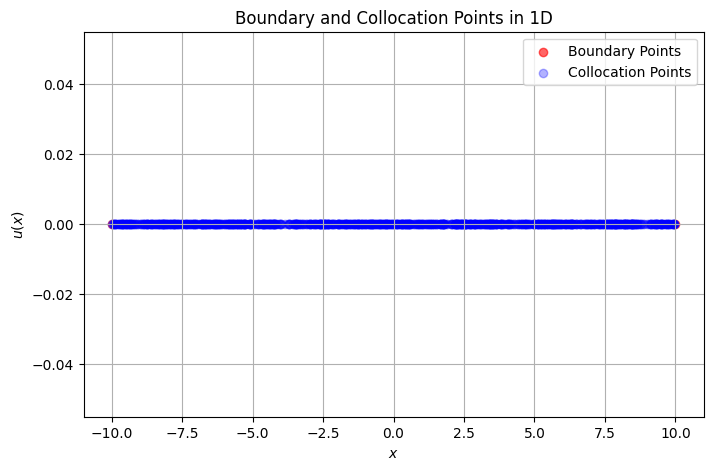

In [10]:
N_u = 2 # Number of boundary points (only needs to be 2 in this example)
N_f = 1000 # Number of collocation points
layers = [1, 200, 200, 200, 1] # Neural network architecture

# Instantiate the PINN model and initialize its weights
model = GrossPitaevskiiPINN(layers).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, verbose=True)

# Generate grid
lb = -10
ub = 10
X = np.linspace(lb, ub, N_f).reshape(-1, 1)

# Prepare training data (collocation and boundary points)
collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

# Visualize training data
visualize_training_data_1D(collocation_points, boundary_points, boundary_values)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/60001], Loss: 1255707.375000


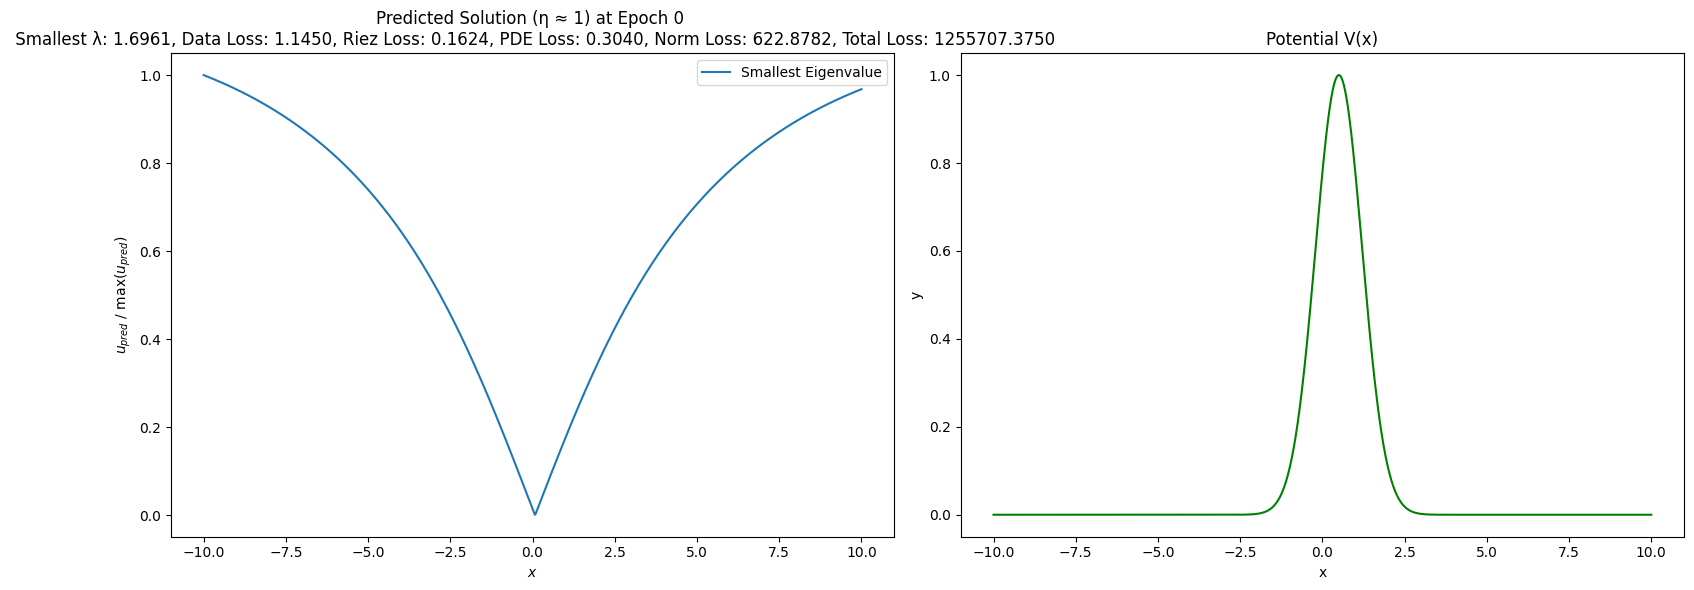

Epoch [10000/60001], Loss: 0.544028


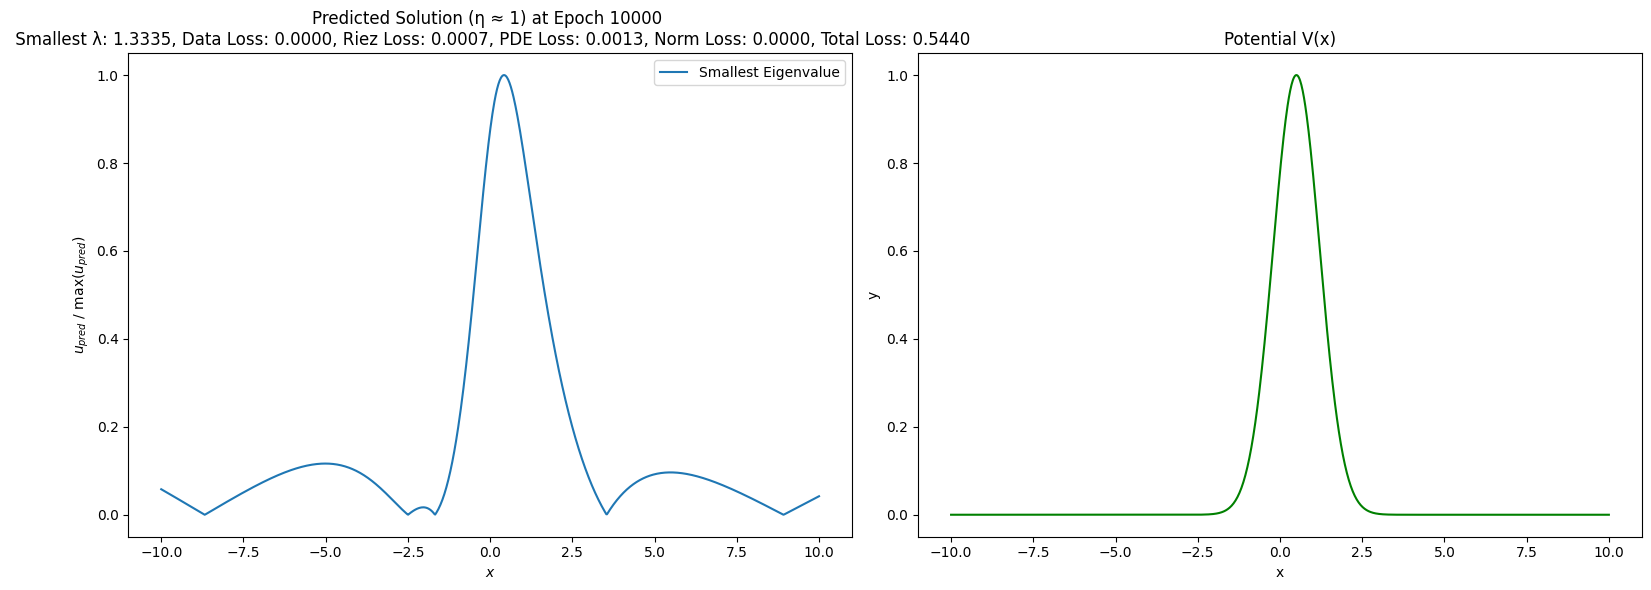

Epoch [20000/60001], Loss: 1.553607


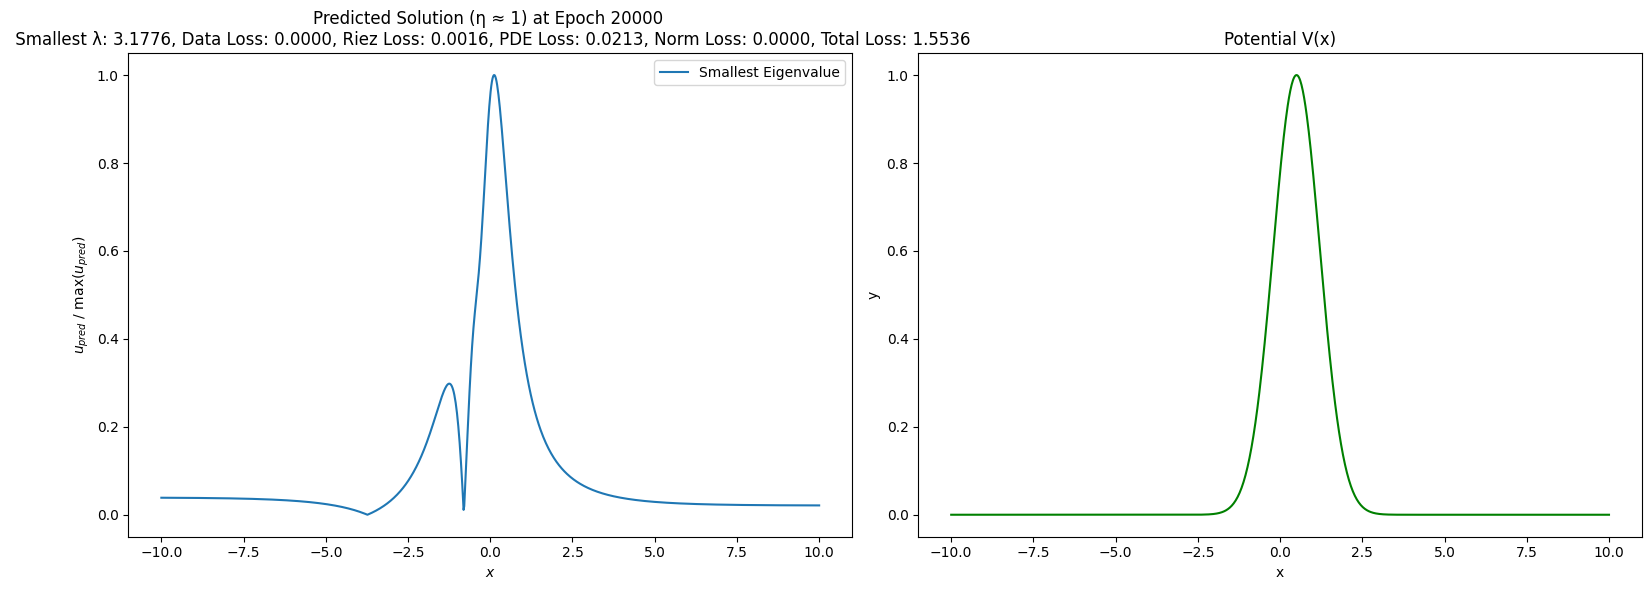

Epoch [30000/60001], Loss: 0.164299


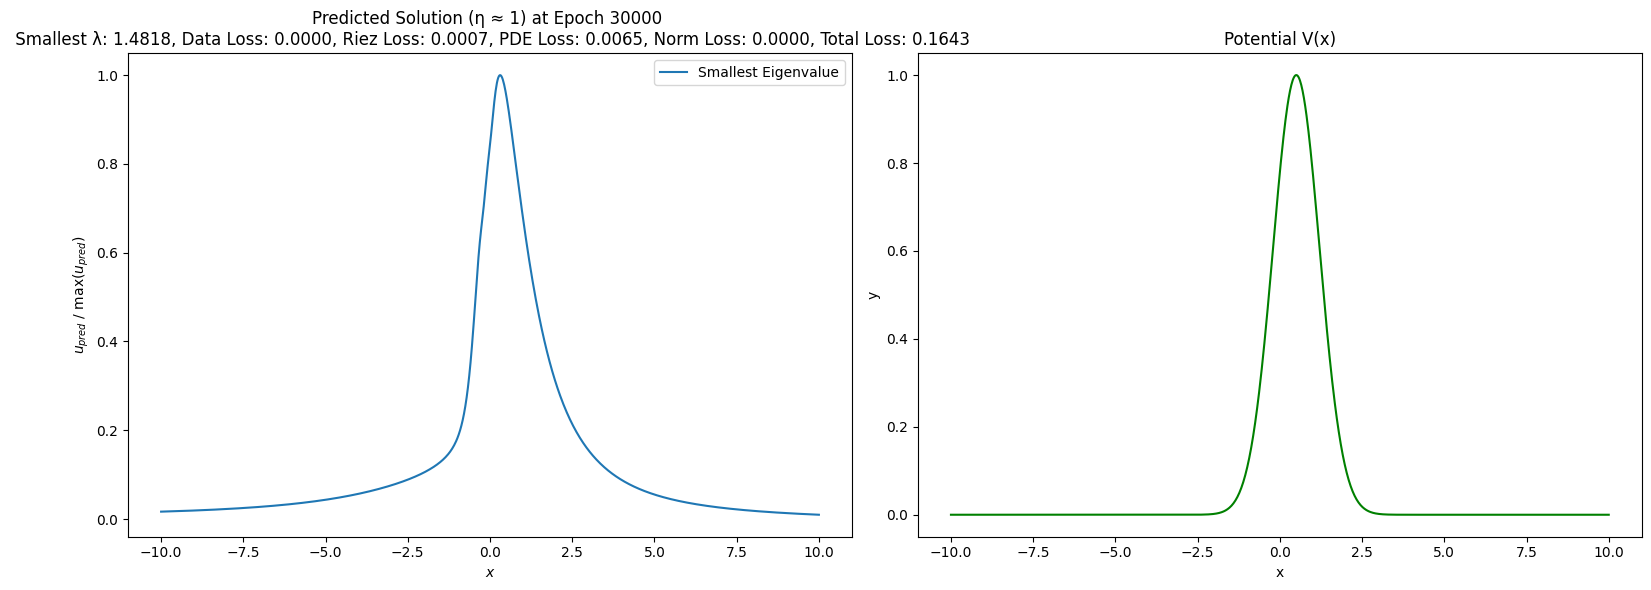

Epoch [40000/60001], Loss: 4.379091


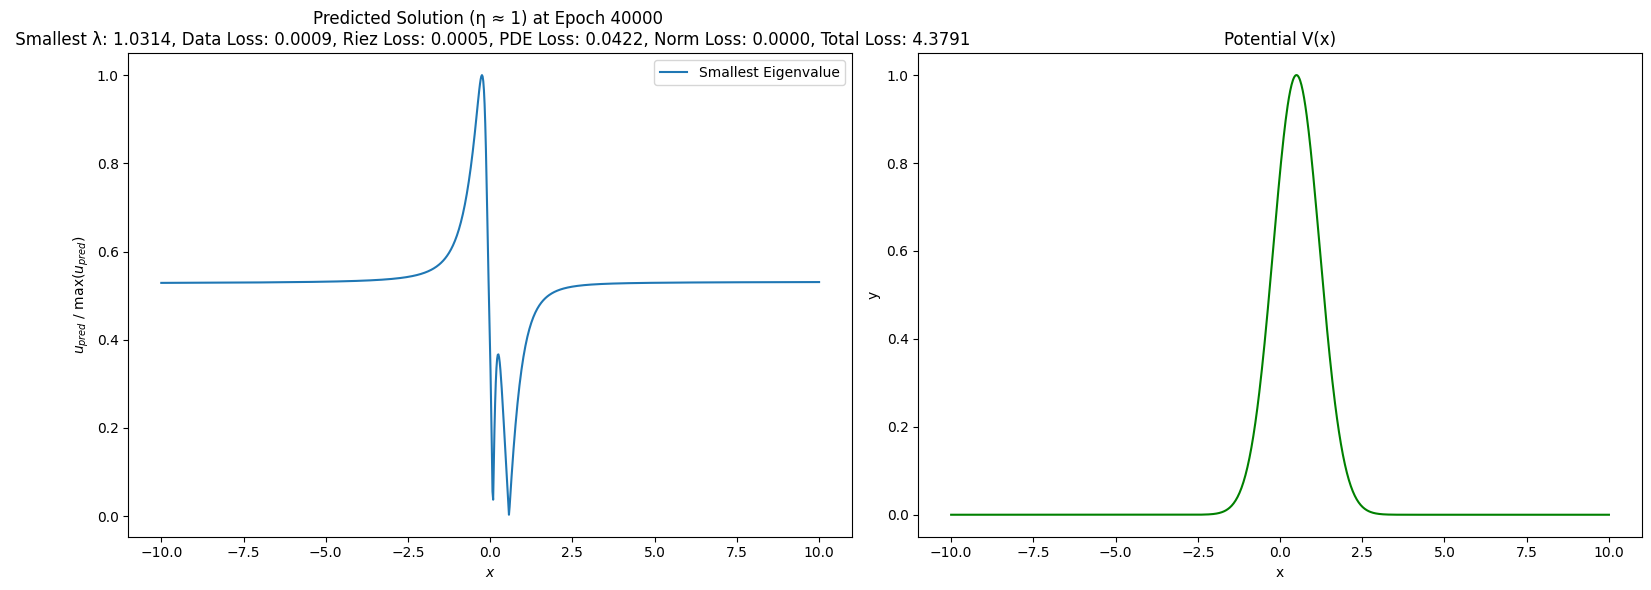

Epoch [50000/60001], Loss: 2.763075


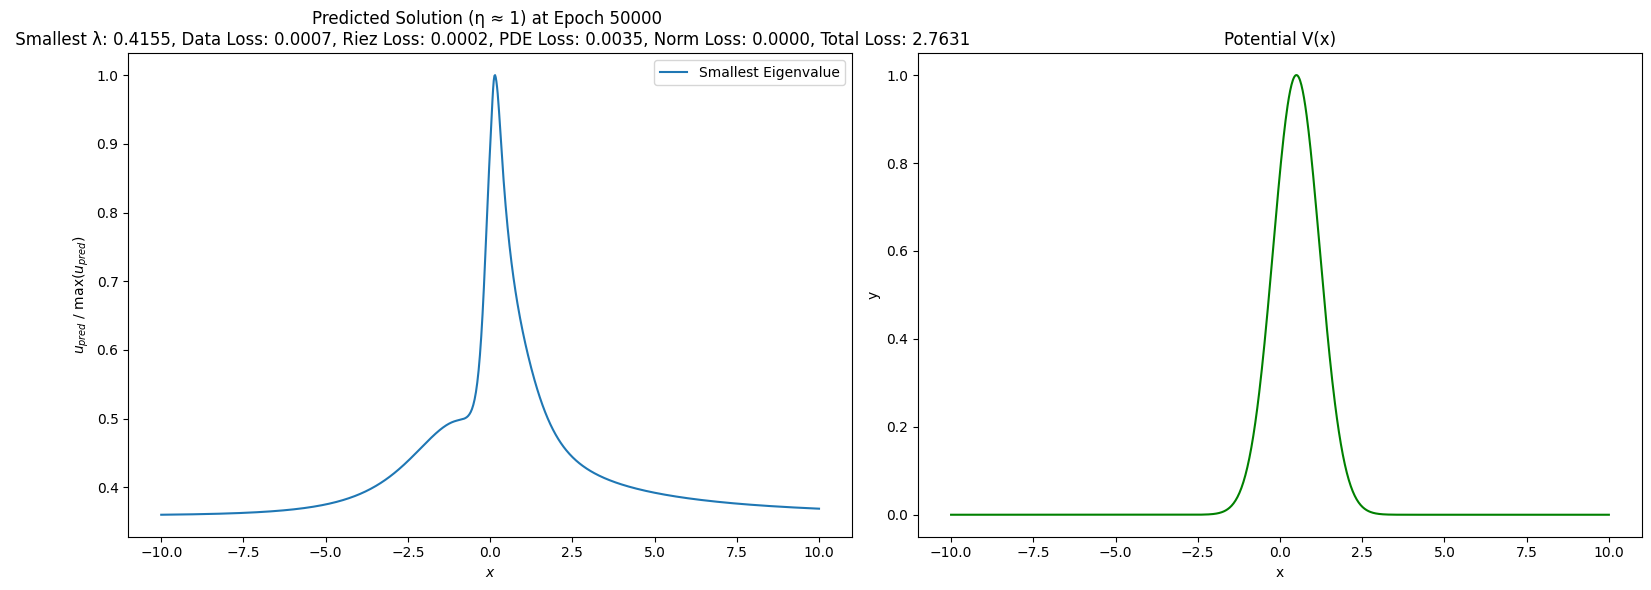

Epoch [60000/60001], Loss: 0.037527


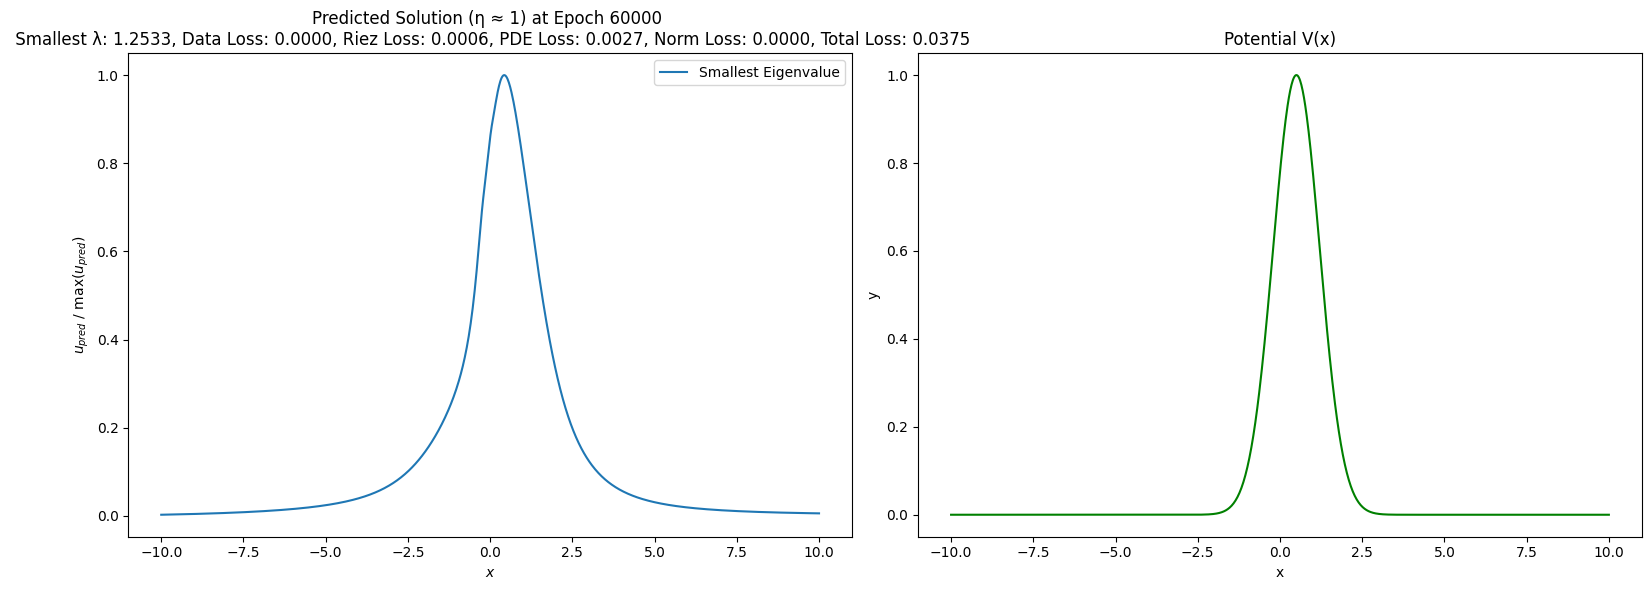

Epoch [0/60001], Loss: 9556.432617


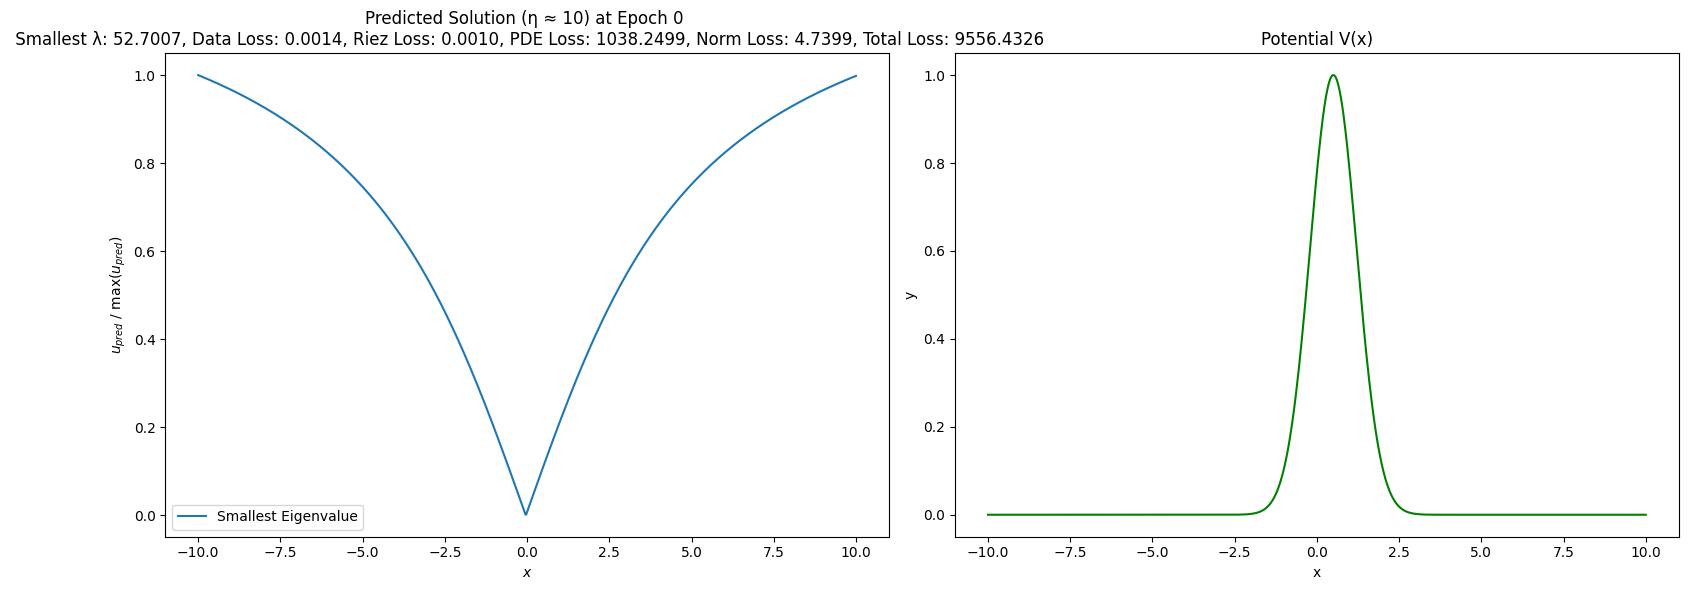

Epoch [10000/60001], Loss: 0.159406


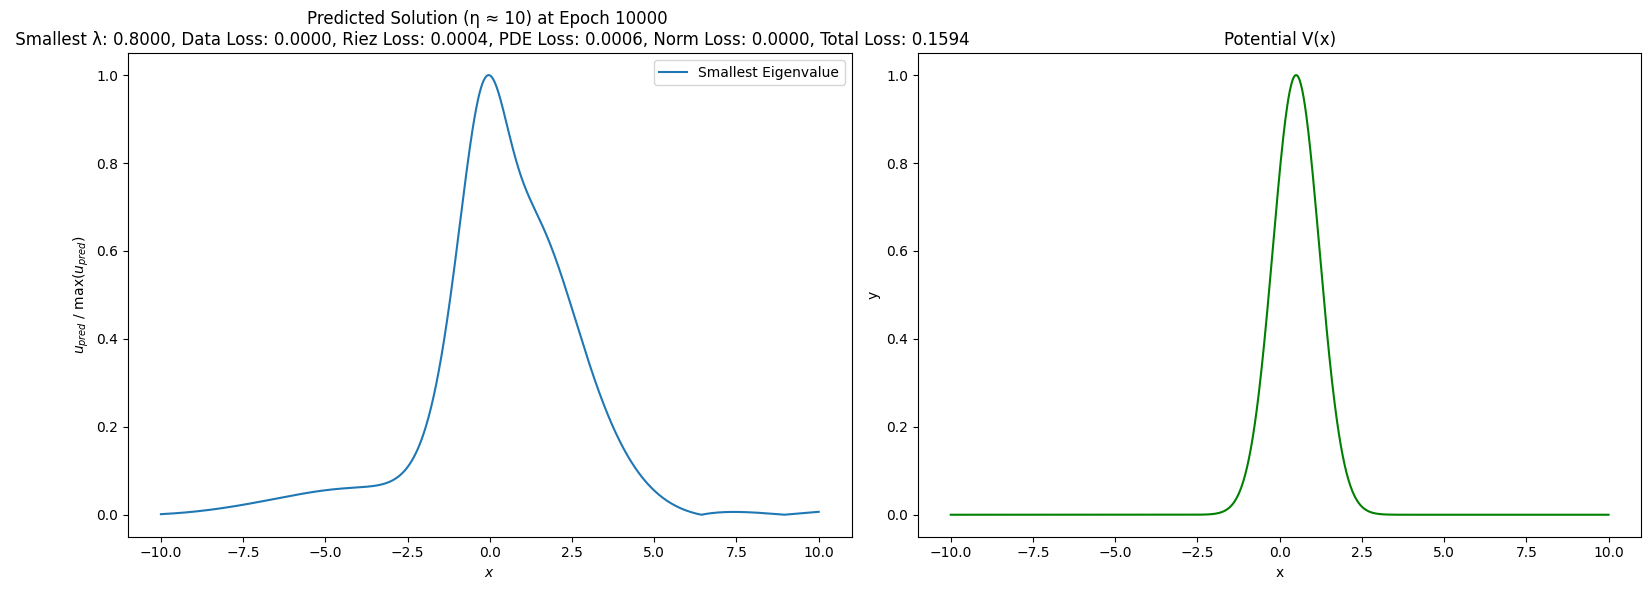

In [ ]:
# Train the PINN

X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points along the 1D interval

etas = [1, 10, 100, 1000] # Interaction strengths
Bs = [4000, 4000, 4000, 4000] # Scaling factors for boundary data loss
Rs = [1, 1, 1, 1] # Scaling factors for Riesz loss
Ps = [10, 10, 10, 10] # Scaling factors for PDE loss
Ns = [2000, 2000, 2000, 2000] # Scaling factors for L^2 Normalization
Ss = [2000, 2000, 2000, 2000] # Scaling factors for Symmetry

models = [GrossPitaevskiiPINN(layers).to(device) for _ in range(4)]
epochs_list = [60001, 60001, 60001, 60001]
x_train = torch.rand(N_f, 1).to(device)

for model, eta, B, R, P, N, S, epochs in zip(models, etas, Bs, Rs, Ps, Ns, Ss, epochs_list):
  model = train_pinn(X, N_u=N_u, N_f=N_f, layers=layers, epochs=epochs, eta=eta, B=B, R=R, P=P, N=N, S=S)

# Generate Final Predicted Solutions

In [ ]:
# Final plot of the predicted solutions

for model, eta in zip(models, etas):

    # Predict the solution by the trained model
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    u_pred = model(X_test_tensor).detach().cpu().numpy()

    plt.plot(X_test, normalize_wave_function(u_pred), label=f'Predicted Solution (η ≈ {eta})')

plt.title('Ground State Solution by PINN (Riesz Method)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()